To run the notebook on Google Collab, uncomment and run the following cells.✅  
⚠️ Change the name of the folder where you download the package on the notebook path in the second cell if necessary. 

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# import os
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

# 0. Import libraries and dataset

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

Import the `Global Crises Data by Country` dataset and the `Maddison Project Database 2020`. 
Preprocess the two dataset with the functions from the `preprocess_dataset` module. The functions are renaming, dropping and changing the data type of certain columns or rows for clarity purpose.

In [14]:
from preprocess_dataset import preprocess_global_crises_data
from preprocess_dataset import preprocess_mdp_data

# Change the relative path file if necessary or set an absolute path file
data = pd.read_csv('../raw_data/global_crisis_data_country.csv', encoding='unicode_escape')
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')

preprocess_global_crises_data(data)
preprocess_mdp_data(GDP_pc)

# 1. Counties selection and primary analysis of the dataset

## Country Lists

The following lists contain country codes representing different groups of countries 🌍.  
The last list `ALL` is created by taking the intersection of unique country codes present in two datasets (`data` and `GDP_pc`). It contains the list of all unique country codes present in both datasets.

In [15]:
# List of countries
OECD = ['DEU', 'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'KOR', 'DNK', 'ESP', 'USA', 'FIN', 'FRA', 'GRC', 'HUN', 'IRL', 'ISL', 'ITA', 'JPN', 'MEX', 'NOR', 'NZL', 'NLD', 'POL', 'PRT', 'GBR', 'SWE', 'CHE', 'TUR']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
G20 = ['DEU', 'CAN', 'FRA', 'GBR', 'JPN', 'ITA', 'USA', 'ZAF', 'SAU', 'RUS', 'CHN', 'ARG', 'BRA', 'IND', 'KOR', 'MEX', 'TUR', 'IDN']
EU = ['DEU', 'FRA', 'AUT', 'BEL', 'DNK', 'ESP', 'NLD', 'POL', 'PRT', 'SWE']
USA = ['USA']

#List for all countries
unique_countries_df1 = set(data['CC3'].unique())
unique_countries_df2 = set(GDP_pc['Code'].unique())
ALL = list(unique_countries_df1.intersection(unique_countries_df2))

Select a list of countries from the predefined lists (`OECD`, `G7`, `G20`, `EU`, `USA`):  
The `countries_selected` variable is assigned one of the predefined country lists (e.g., `G7`). You can choose any list among those defined above.

In [16]:
#Select a list among those listed above. Change to any desired list defined above.
countries_selected = ALL

## Dataset selection and creation

This cell creates a dataset containing the data for the countries selected.

- The `concat_dataset` function is then called to create a dataset (`global_data_left`) by concatenating the data from two datasets (`data` and `GDP_pc`) for the selected countries with a type of jointure `Left`.
- Finally, the `dummy_variable` function is applied to the `global_data` dataset to perform any necessary preprocessing or feature engineering.`
`.
The resulting `global_data` dataset contains the merged data for the selected countries, along with any additional preprocessing applied by the `dummy_variable` function.


In [17]:
from dataset import concat_dataset
from dataset import dummy_variable

#Create a dataset with the data of the countries of the list
global_data_left = concat_dataset(data, GDP_pc, countries_selected, 'left', )

# Perform any necessary preprocessing or feature engineering
dummy_variable(global_data_left)

# Display the resulting dataset (here the first 5 rows)
global_data_left.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,57.0,ESP,Spain,1800,0.0,NaN,0.0,NaN,NaN,NaN,...,NaN,-4.1,1,0,0.0,NaN,0,0,0,1
1,57.0,ESP,Spain,1801,0.0,NaN,0.0,NaN,NaN,NaN,...,NaN,14.2,1,0,0.0,NaN,0,0,0,1
2,57.0,ESP,Spain,1802,0.0,NaN,0.0,NaN,NaN,NaN,...,NaN,15.7,1,0,0.0,NaN,0,0,0,1
3,57.0,ESP,Spain,1803,0.0,NaN,0.0,NaN,NaN,NaN,...,NaN,34.1,1,0,1.0,NaN,0,1,0,0
4,57.0,ESP,Spain,1804,0.0,NaN,0.0,NaN,NaN,NaN,...,NaN,16.2,1,0,0.0,NaN,0,0,0,1


## Analysis of the banking crises and their duration in the dataset

Compute the duration of each banking crisis of the dataset and provide a distribution of crisis durations in the dataset.

- The `compute_crisis_duration` function from the `extraction_method_1` module is imported to calculate the duration of crisis events in the `global_data_left` dataset.
- The `crisis_duration_left` variable is assigned the result of calling the `compute_crisis_duration` function on the `global_data_left` dataset. This variable contains a list of crisis durations.
- The `length_frequency` function from the `extraction_method_1` module is imported to compute the frequency of different crisis durations.
- The `frequency_table_left` variable is assigned the result of calling the `length_frequency` function on the `crisis_duration_left` list. This variable contains a frequency table showing the number of crisis events of each duration.

In [18]:
from extraction_method_1 import compute_crisis_duration
from extraction_method_1 import length_frequency

# Calculate the duration of crisis events
crisis_duration_left = compute_crisis_duration(global_data_left)

# Compute the frequency of different crisis durations
frequency_table_left = length_frequency(crisis_duration_left)

# Display the table
frequency_table_left

,Length_of_crisis,Number_of_crisis_event
0,1,95
1,2,37
2,3,16
3,4,16
4,5,6
5,6,4
6,7,10
7,8,3
8,9,1
9,10,1


# 2. Annual inflation rate analysis

## Data Extraction and Normalization

Extracts the inflation series from the `global_data_left` dataset using the `extract_inflation_series` function from the `functionsA` module. \
Normalize the extracted inflation series to the first element of each serie (ts-1) data using the `normalize_crisis_data` function from the `functionsA` module.  \
Store the result in the list `norm_inflation_series`.

In [19]:
from extraction_method_1 import extract_inflation_series
from extraction_method_1 import normalize_serie

inflation_series = extract_inflation_series(global_data_left)
norm_inflation_series = normalize_serie(inflation_series)

## Visualization of Inflation Rate reaction by Crisis Length

This cell visualizes average reaction of the inflation rate to a banking crisis depending on the crisis length using functions from the `visualisation` module.

1. The `plot_by_crisis_length` and `plot_all_crisis_length` functions from the `visualisation` module are imported.
2. The `plot_by_crisis_length` function can be called with the following 5 arguments:
   - `norm_inflation_series`: The normalized inflation series data.
   - `crisis_duration_left`: The list containing the duration of each crisis event.
   - `frequency_table_left`: The DataFrame containing the frequency of each crisis duration.
   - `'Inflation rate'`: The label for the y-axis of the plot.
   - `desired_length`: The duration of the banking crisis to which the inflation rate reacts.
3. The `plot_all_crisis_length` function can be called with the first 4 arguments listed above and can plot the average reaction of the inflation rate to to all the different durations of banking crises.

The resulting plots visualizes the difference of reaction of the inflation rate to banking crisis of different length. The plots are also displaying the number of data points from which the average has been computed.

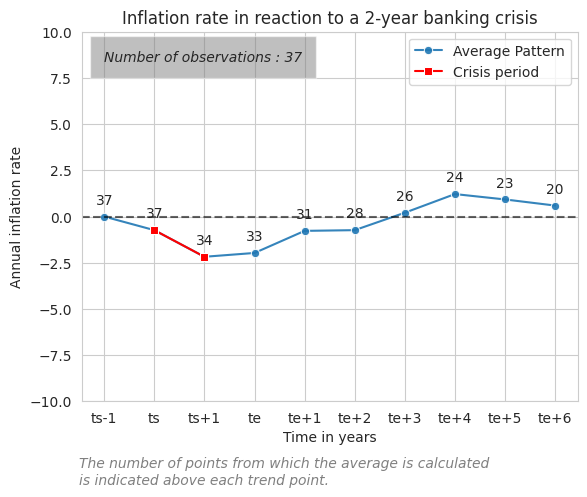

In [20]:
from visualisation import plot_by_crisis_length
from visualisation import plot_all_crisis_length

# Plot the average reaction of the inflation rate to a banking crisis of a particular length specified in the last argument of the following function
plot_by_crisis_length(norm_inflation_series, crisis_duration_left, frequency_table_left, 'Inflation rate', 2) # Change the last argument to the desired duration of crisis

Uncomment the following cell to plot the reaction for every length of banking crisis 📈📉.

In [30]:
# # Plot the average reaction of the inflation rate to banking crisis of a particular length specified in the last argument of the following function
# plot_all_crisis_length(norm_inflation_series, crisis_duration_left, frequency_table_left, 'Inflation rate')

# 3. Output-gap analysis

## Dataset selection and creation

This cell creates a dataset containing the data for the countries selected.

- The `concat_dataset` function is then called to create a dataset (`global_data_inner`) by concatenating the data from two datasets (`data` and `GDP_pc`) for the selected countries with a type of jointure `Inner` on the *Year* and *Country Code* columns. This type of jointure is used to avoid NaN values in the *output_gap* column as the `GDP_pc` does not have data as old as the `data` database.
- The `dummy_variable` function is applied to the `global_data` dataset to perform any necessary preprocessing or feature engineering.`
`.
The resulting `global_data` dataset contains the merged data for the selected countries, along with any additional preprocessing applied by the `dummy_variable` function.

In [31]:
# Create a dataset with the data of the countries of the list countries_selected
global_data_inner = concat_dataset(data, GDP_pc, countries_selected, 'inner')

# Perform any necessary preprocessing or feature engineering
dummy_variable(global_data_inner)

# Display the resulting dataset (here the first 5 rows)
global_data_inner.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,9.0,CAN,Canada,1820,0.0,NaN,0.0,0,0.2627,NaN,...,NaN,NaN,0,0,0.0,1.86,0,0,0,0
1,9.0,CAN,Canada,1830,0.0,NaN,0.0,0,0.2465,NaN,...,NaN,NaN,0,0,0.0,-3.61,0,0,0,0
2,9.0,CAN,Canada,1840,0.0,NaN,0.0,0,0.2561,NaN,...,NaN,NaN,0,0,0.0,-2.36,0,0,0,0
3,9.0,CAN,Canada,1850,0.0,NaN,0.0,0,0.2566,NaN,...,NaN,NaN,0,0,0.0,-0.88,0,0,0,0
4,9.0,CAN,Canada,1860,0.0,NaN,0.0,1,0.9902,NaN,...,NaN,NaN,0,0,0.0,-2.29,0,0,0,0


In [32]:
# Calculate the duration of crisis events
crisis_duration_inner = compute_crisis_duration(global_data_inner)

# Compute the frequency of different crisis durations and display the table
frequency_table_inner = length_frequency(crisis_duration_inner)
frequency_table_inner

,Length_of_crisis,Number_of_crisis_event
0,1,32
1,2,12
2,3,8
3,4,3
4,6,1
5,7,2
6,8,2
7,10,1


## Data Extraction and Normalization

Extracts the inflation series from the `global_data_inner` dataset using the `extract_output_gap_series` function from the `functionsA` module. \
Store the result in the list `output_gap_series`.

In [33]:
from extraction_method_1 import extract_output_gap_series

output_gap_series = extract_output_gap_series(global_data_inner)

## Visualization of output gap average reaction by Crisis Length

This cell visualizes the average reaction of the output gap to banking crises depending on the crisis length using functions from the `visualisation` module.

The functions `plot_by_crisis_length` and `plot_all_crisis_length` from the `visualisation` module are imported. \
The two functions can be called as explained in the Inflation-rate analysis part, one displaying the average reaction to a a specific duration of banking crisis, the other for every length of crisis.


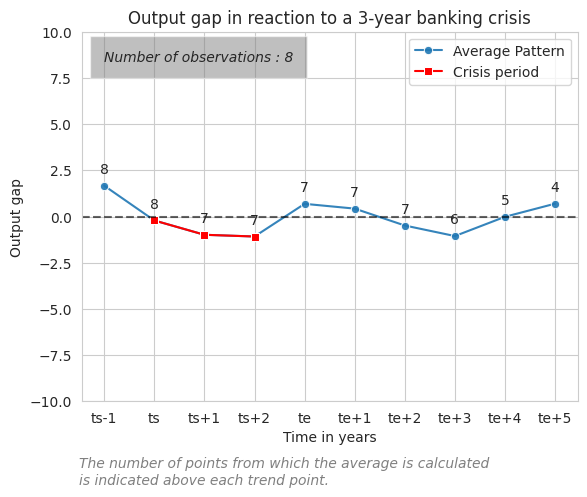

In [40]:
# Plot the average reaction of the output gap to a banking crisis of a particular length specified in the last argument of the following function
plot_by_crisis_length(output_gap_series, crisis_duration_inner, frequency_table_inner, 'Output gap', 3)

Uncomment the following cell to plot the reaction for every length of banking crisis 📈📉.

In [41]:
## Plot the average reaction of the output gap to banking crisis of all durations
# plot_all_crisis_length(output_gap_series, crisis_duration_inner, frequency_table_inner, 'Output gap')

# 4. Crisis & recovery Dynamics in a multiple country database

This last part aims to study how the macroeconomic (inflation rate & output gap) variables are behaving as the banking crisis & the recovery lasts for an additional year.

We first import the functions `inflation_dynamics`, `output_gap_dynamics` and `plot_dynamics` from the `extraction_method_1` and `visualisation` modules.

In [35]:
from extraction_method_1 import inflation_dynamics
from extraction_method_1 import output_gap_dynamics
from visualisation import plot_dynamics

#### `inflation_dynamics`

This function extracts series of annual inflation rates for each banking crisis or recovery period from a given dataset containing crisis event information. It takes two arguments:
- `data`: A DataFrame containing crisis event information.
- `during_crisis`: A boolean indicating whether to extract series for banking crisis period (`True`) or recovery periods (`False`). Default is `True`.

#### `output_gap_dynamics`

This function extracts series of annual output gap for each banking crisis or recovery period from a given dataset containing crisis event information. It takes two arguments:
- `data`: A DataFrame containing crisis event information.
- `during_crisis`: A boolean indicating whether to extract series for banking crisis period (`True`) or recovery periods (`False`). Default is `True`.

#### `normalize_serie`

The `normalize_serie` function normalizes each sublist in a given list based on its first element. It takes one argument:
- `lst`: A list of lists, where each sublist represents a series of crisis data.

#### `plot_dynamics`

The `plot_dynamics` function plots the inflation rate during banking crisis and recovery periods. It computes the average response pattern by time elapsed with and without normalizing the inflation series. It takes three arguments:
- `crisis_series`: A list of lists representing inflation series during banking crises.
- `recovery_series`: A list of lists representing inflation series during recovery periods.
- `string`: A string indicating the variable being plotted (e.g., inflation rate).

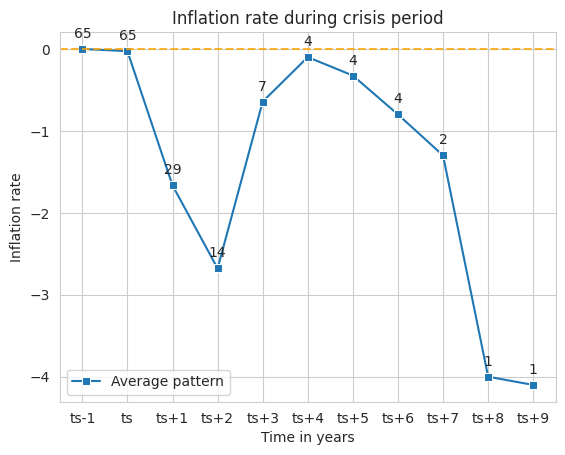

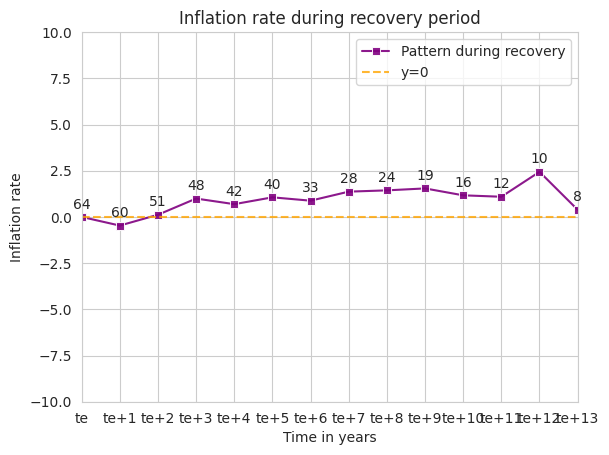

In [36]:
# Extract the inflation series only for the years marked as a banking crisis / recovery year from the global_data_left dataframe and normalize the series
inflation_crisis_series = normalize_serie(inflation_dynamics(global_data_left, during_crisis = True))
inflation_recovery_series = normalize_serie(inflation_dynamics(global_data_left, during_crisis = False))

# Compute the average evolution and plot it
plot_dynamics(inflation_crisis_series, inflation_recovery_series, 'Inflation rate')

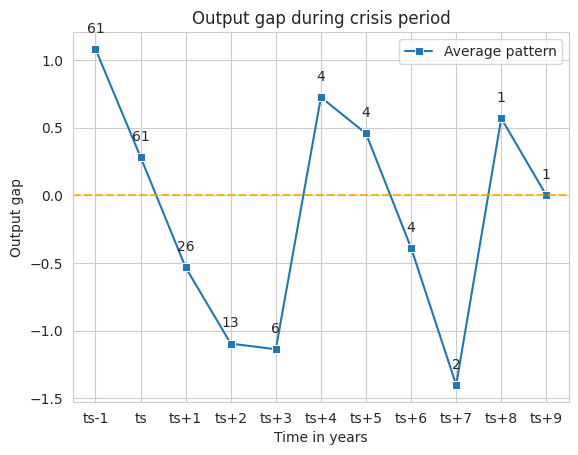

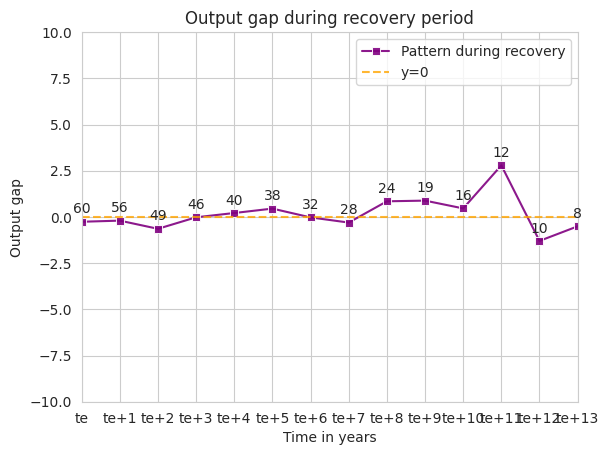

In [37]:
# Extract the inflation series only for the years marked as a banking crisis / recovery year from the global_data_left dataframe and normalize the series
output_gap_crisis_series = output_gap_dynamics(global_data_inner, during_crisis = True)
output_gap_recovery_series = output_gap_dynamics(global_data_inner, during_crisis = False)

# Compute the average evolution and plot it
plot_dynamics(output_gap_crisis_series, output_gap_recovery_series, 'Output gap')